## CutMix/Mixup 비교실험

### Comparison overview

1. No Augmentation
2. 기본 Augmentation (affine transformation only)
3. No + Mixup 적용
4. No + CutMix 적용
5. Label smoothing

### Todo

1. 훈련 과정의 히스토리를 그래프로 시각화
2. 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능 비교
3. Augmentation 방법들의 영향도에 대해 분석

### Import necessary libs

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import warnings

warnings.filterwarnings("ignore")
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load datasets

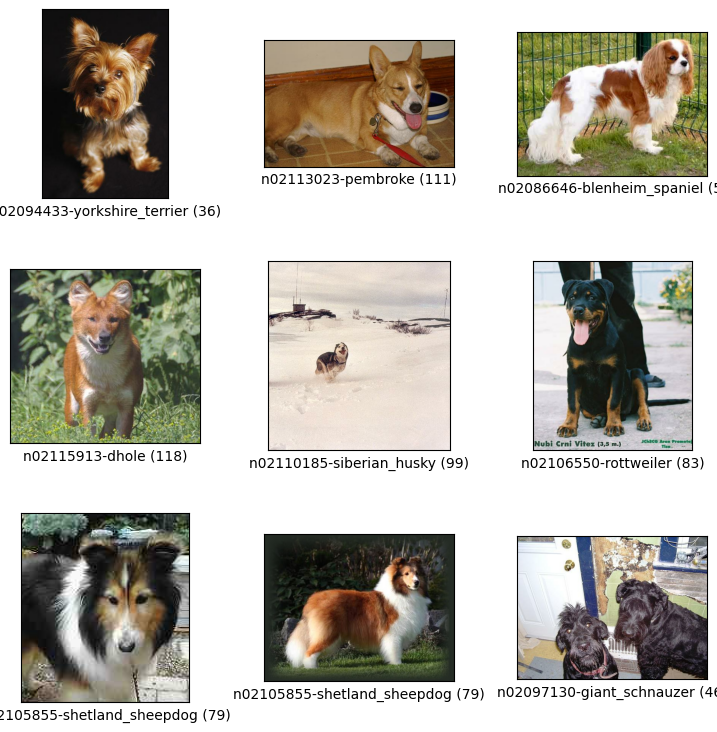

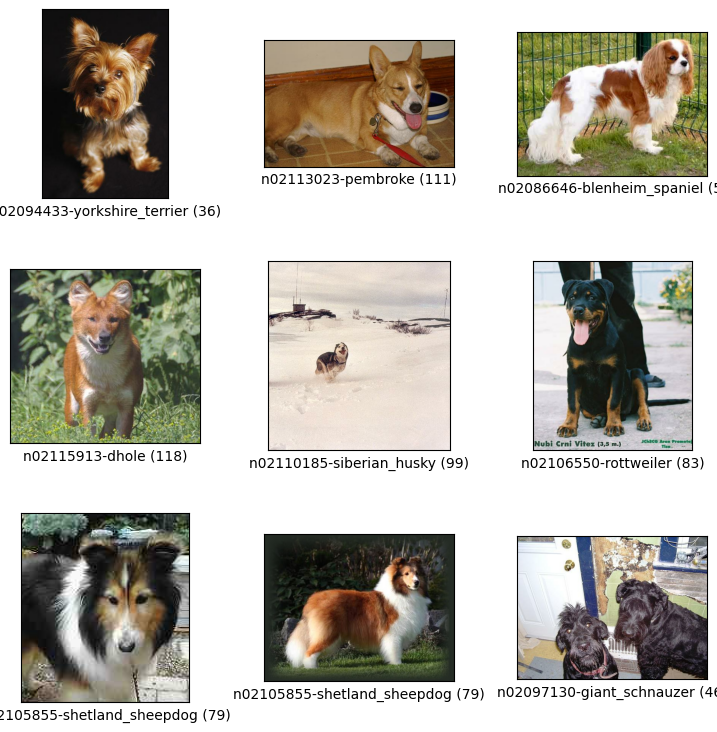

In [4]:
(ds_train, dss_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)
tfds.show_examples(ds_train, ds_info)

### Implement preprocess methods

In [16]:
# 이미지 merge 위치 지정
def get_clip_box(image_a):
    image_size_x, image_size_y = image_a.shape[1], image_a.shape[0]
    x = tf.random.uniform([], 0, image_size_x, dtype=tf.int32)
    y = tf.random.uniform([], 0, image_size_y, dtype=tf.int32)
    width = tf.cast(image_size_x * tf.sqrt(1 - tf.random.uniform([])), tf.int32)
    height = tf.cast(image_size_y * tf.sqrt(1 - tf.random.uniform([])), tf.int32)
    x_min = tf.maximum(0, x - width // 2)
    y_min = tf.maximum(0, y - height // 2)
    x_max = tf.minimum(image_size_x, x + width // 2)
    y_max = tf.minimum(image_size_y, y + height // 2)
    return x_min, y_min, x_max, y_max

# 이미지 병합
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    middle = tf.concat([image_a[y_min:y_max, 0:x_min, :], image_b[y_min:y_max, x_min:x_max, :], image_a[y_min:y_max, x_max:, :]], axis=1)
    return tf.concat([image_a[:y_min, :, :], middle, image_a[y_max:, :, :]], axis=0)

# 레이블 병합
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, total_area):
    area_box = (x_max - x_min) * (y_max - y_min)
    ratio = tf.cast(area_box / total_area, tf.float32)
    return (1 - ratio) * label_a + ratio * label_b

# cutmix 구현
def cutmix(image, label, batch_size=32):
    mixed_imgs, mixed_labels = [], []
    for i in range(batch_size):
        image_a, label_a = image[i], label[i]
        j = tf.random.uniform([], 0, batch_size, dtype=tf.int32)
        image_b, label_b = image[j], label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a.shape[1] * image_a.shape[0]))
    return tf.stack(mixed_imgs), tf.stack(mixed_labels)

In [6]:
# 이미지 병합
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_image, mixed_label

# mixup 구현
def mixup(image, label, batch_size=32):
    mixed_imgs, mixed_labels = [], []
    for i in range(batch_size):
        j = tf.random.uniform([], 0, batch_size, dtype=tf.int32)
        mixed_img, mixed_label = mixup_2_images(image[i], image[j], label[i], label[j])
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
    return tf.stack(mixed_imgs), tf.stack(mixed_labels)

In [17]:
num_classes = ds_info.features["label"].num_classes

# 이미지 사이즈 조정
def image_norm(i, l):
    return tf.cast(tf.image.resize(i, [224, 224]), tf.float32) / 255.0, l

# 이미지 affine transformation 수행
def image_aug(i, l):
    transforms = tf.constant([
        [1.5, 0, -20, 0, 1.5, -16, 0, 0],       # zoom
        [1, 0, -20, 0, 1, -16, 0, 0],           # translation upper left
        [1, 0, 50, 0, 1, 30, 0, 0],             # translation bottom right
        [1.0, 0.5, -20, 0.5, 1.0, -16, 0, 0],   # shear
        [0.866, 0.5, 0, -0.5, 0.866, 0, 0, 0],  # rotation
        [0.6667, 0, 20, 0, 0.6667, 16, 0, 0],   # opposite of zoom
        [1, 0, 20, 0, 1, 16, 0, 0],             # opposite of translation upper left
        [1, 0, -50, 0, 1, -30, 0, 0],           # opposite of translation bottom right
        [1.0, -0.5, 20, -0.5, 1.0, 16, 0, 0],   # opposite of shear
        [0.866, -0.5, 0, 0.5, 0.866, 0, 0, 0],  # opposite of rotation
    ])
    transform = transforms[tf.random.uniform([], 0, len(transforms), dtype=tf.int32)]
    i = tf.image.random_flip_left_right(i)
    i = tfa.image.transform(i, transform)
    return tf.clip_by_value(i, 0, 1), l

# one hot encoding 수행
def one_hot(i, l):
    l = tf.one_hot(l, num_classes)
    return i, l

# 라벨 스무딩 구현
def label_smoothing(i, l, num_classes=num_classes, factor=0.1):
    l = l * (1 - factor) + (factor / num_classes)
    return i, l

# input choices에 따라 preprocess 수행
def apply_preprocess(ds, is_test=False, batch_size=32, with_aug=False, with_cutmix=False, with_mixup=False, with_smooth=False):
    ds = ds.map(image_norm, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(one_hot, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if not is_test:
        if with_aug:
            ds = ds.map(image_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.shuffle(buffer_size=200).repeat().batch(batch_size)
        if with_cutmix:
            ds = ds.map(cutmix, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        elif with_mixup:
            ds = ds.map(mixup, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        elif with_smooth:
            ds = ds.map(label_smoothing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# 데이터 셋 생성
ds_test = apply_preprocess(dss_test, is_test=True)
ds_train_no_aug = apply_preprocess(ds_train)
ds_train_aug = apply_preprocess(ds_train, with_aug=True)
ds_train_mixup = apply_preprocess(ds_train, with_mixup=True)
ds_train_cutmix = apply_preprocess(ds_train, with_cutmix=True)
ds_train_smooth = apply_preprocess(ds_train, with_smooth=True)

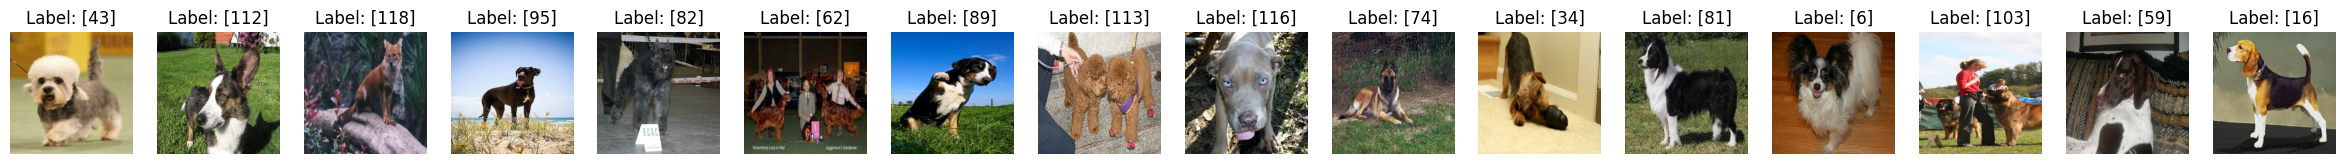

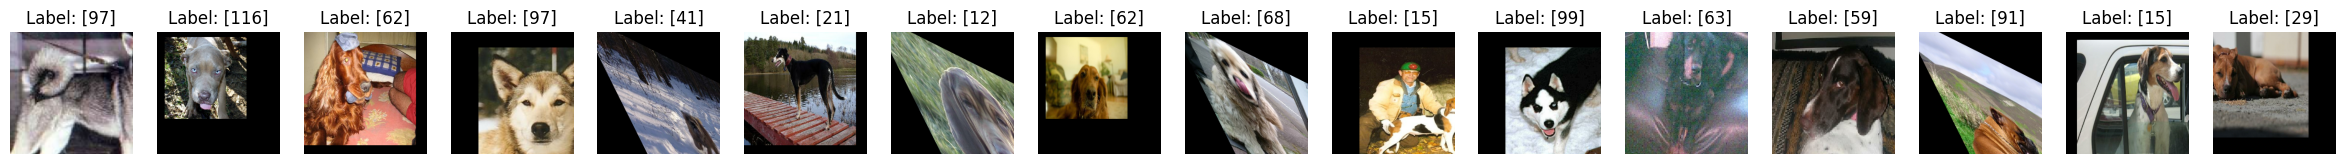

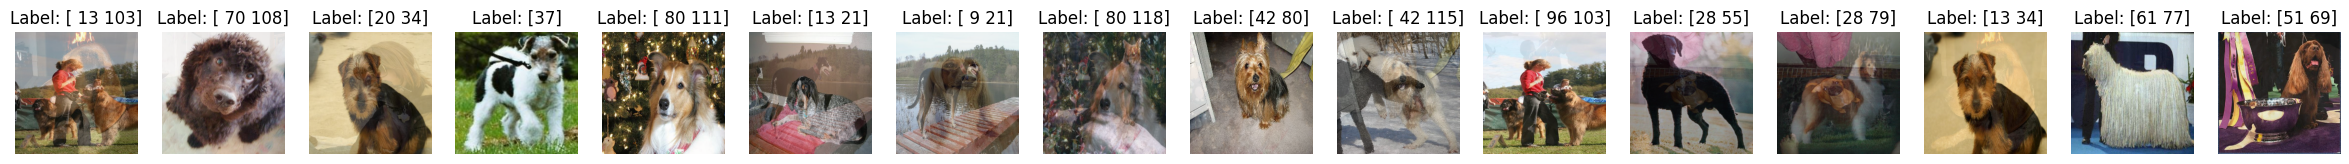

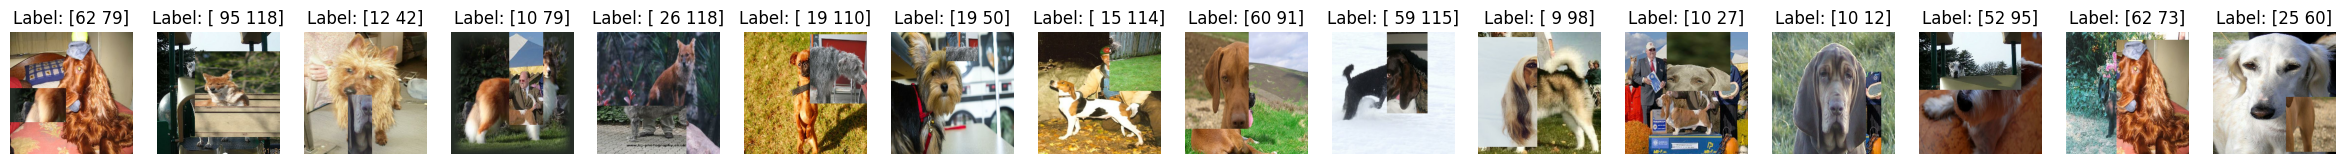

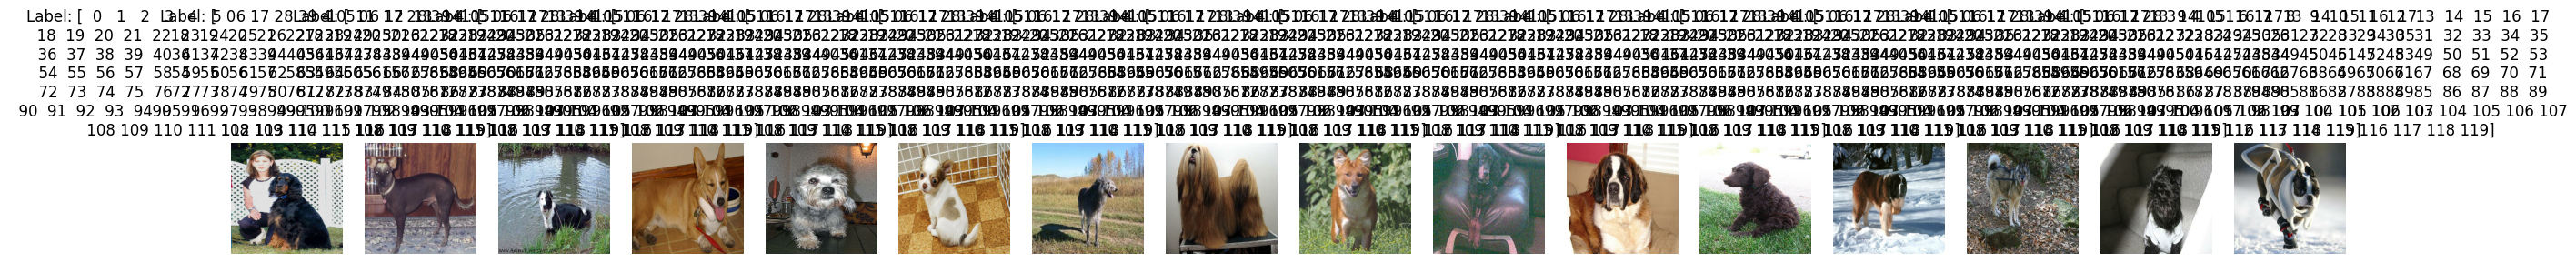

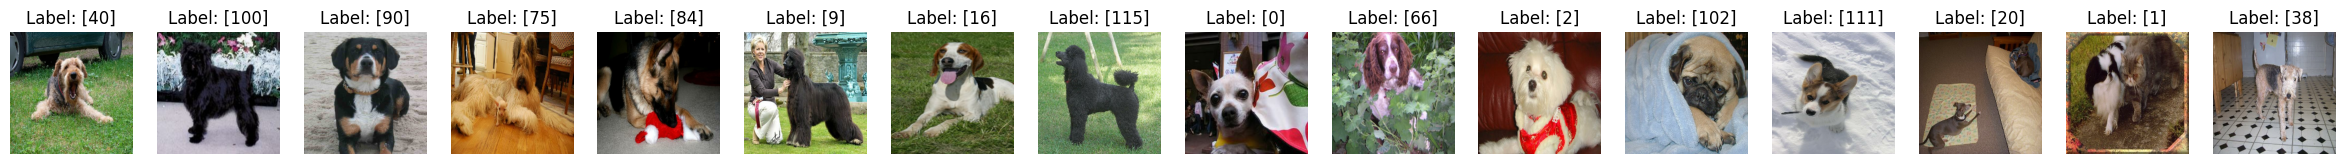

In [9]:
# 순서대로 no aug, aug, mixup, cutmix, label smoothing, test 데이터 셋 display
for dss in [ds_train_no_aug, ds_train_aug, ds_train_mixup, ds_train_cutmix, ds_train_smooth, ds_test]:
    for images, labels in dss.take(1):
        fig, axs = plt.subplots(1, 16, figsize=(30, 4))
        for i in range(16):
            axs[i].imshow(images[i].numpy())
            axs[i].set_title(f"Label: {np.where(labels[i].numpy() != 0)[0]}")
            axs[i].axis("off")
        plt.show()

### Model

In [32]:
def train_model(train, epoch=50, initial_epochs=0, trained_model=None, batch_size=32):
    if initial_epochs == 0:
        model = keras.models.Sequential([
            keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
            keras.layers.Dense(num_classes, activation='softmax')])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])
    model = trained_model
    hist = model.fit(
        train, initial_epoch=initial_epochs,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epoch, validation_data=ds_test, verbose=1, use_multiprocessing=True)
    return model, hist

In [10]:
model1, hist_model1 = train_model(ds_train_no_aug)

Epoch 1/50


2024-10-15 23:13:08.285702: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-10-15 23:13:11.574905: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ef8eb8397a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-15 23:13:11.574936: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
I0000 00:00:1729001591.618479  437150 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 [==============================] - 129s 296ms/step - loss: 2.5799 - accuracy: 0.3972 - val_loss: 4.9671 - val_accuracy: 0.0087
Epoch 2/50
375/375 [==============================] - 109s 290ms/step - loss: 0.9020 - accuracy: 0.7561 - val_loss: 2.8728 - val_accuracy: 0.2961
Epoch 3/50
375/375 [==============================] - 109s 291ms/step - loss: 0.4294 - accuracy: 0.9036 - val_loss: 1.0945 - val_accuracy: 0.6840
Epoch 4/50
375/375 [==============================] - 109s 291ms/step - loss: 0.2161 - accuracy: 0.9618 - val_loss: 0.9932 - val_accuracy: 0.7058
Epoch 5/50
375/375 [==============================] - 109s 291ms/step - loss: 0.1159 - accuracy: 0.9877 - val_loss: 0.9607 - val_accuracy: 0.7185
Epoch 6/50
375/375 [==============================] - 109s 292ms/step - loss: 0.0733 - accuracy: 0.9942 - val_loss: 0.9584 - val_accuracy: 0.7228
Epoch 7/50
375/375 [==============================] - 109s 291ms/step - loss: 0.0516 - accuracy: 0.9963 - val_loss: 0.9605 - val_accura

In [11]:
model2, hist_model2 = train_model(ds_train_aug)

Epoch 1/50
375/375 [==============================] - 120s 294ms/step - loss: 3.2123 - accuracy: 0.2677 - val_loss: 4.9947 - val_accuracy: 0.0075
Epoch 2/50
375/375 [==============================] - 110s 294ms/step - loss: 1.6664 - accuracy: 0.5484 - val_loss: 2.3334 - val_accuracy: 0.3780
Epoch 3/50
375/375 [==============================] - 110s 295ms/step - loss: 1.2984 - accuracy: 0.6343 - val_loss: 1.1604 - val_accuracy: 0.6582
Epoch 4/50
375/375 [==============================] - 111s 295ms/step - loss: 1.0997 - accuracy: 0.6845 - val_loss: 1.0857 - val_accuracy: 0.6781
Epoch 5/50
375/375 [==============================] - 110s 294ms/step - loss: 0.9530 - accuracy: 0.7210 - val_loss: 1.3321 - val_accuracy: 0.6319
Epoch 6/50
375/375 [==============================] - 110s 294ms/step - loss: 0.8468 - accuracy: 0.7539 - val_loss: 1.2046 - val_accuracy: 0.6549
Epoch 7/50
375/375 [==============================] - 110s 294ms/step - loss: 0.7552 - accuracy: 0.7815 - val_loss: 1.1365 -

In [12]:
model3, hist_model3 = train_model(ds_train_mixup)

Epoch 1/50
375/375 [==============================] - 120s 294ms/step - loss: 3.9496 - accuracy: 0.2024 - val_loss: 6.2233 - val_accuracy: 0.0147
Epoch 2/50
375/375 [==============================] - 110s 294ms/step - loss: 2.9026 - accuracy: 0.4799 - val_loss: 3.4753 - val_accuracy: 0.2057
Epoch 3/50
375/375 [==============================] - 110s 294ms/step - loss: 2.6360 - accuracy: 0.5723 - val_loss: 1.3180 - val_accuracy: 0.6466
Epoch 4/50
375/375 [==============================] - 110s 295ms/step - loss: 2.4716 - accuracy: 0.6396 - val_loss: 1.2241 - val_accuracy: 0.6625
Epoch 5/50
375/375 [==============================] - 110s 294ms/step - loss: 2.3547 - accuracy: 0.6781 - val_loss: 1.2526 - val_accuracy: 0.6561
Epoch 6/50
375/375 [==============================] - 110s 295ms/step - loss: 2.2762 - accuracy: 0.7113 - val_loss: 1.2409 - val_accuracy: 0.6616
Epoch 7/50
375/375 [==============================] - 110s 294ms/step - loss: 2.1994 - accuracy: 0.7377 - val_loss: 1.1373 -

In [19]:
model4, hist_model4 = train_model(ds_train_cutmix)

Epoch 1/50
375/375 [==============================] - 125s 308ms/step - loss: 4.0693 - accuracy: 0.1665 - val_loss: 5.1725 - val_accuracy: 0.0087
Epoch 2/50
375/375 [==============================] - 117s 312ms/step - loss: 3.0762 - accuracy: 0.4001 - val_loss: 2.8379 - val_accuracy: 0.2899
Epoch 3/50
375/375 [==============================] - 118s 316ms/step - loss: 2.7571 - accuracy: 0.4988 - val_loss: 1.3531 - val_accuracy: 0.6260
Epoch 4/50
375/375 [==============================] - 119s 317ms/step - loss: 2.5650 - accuracy: 0.5523 - val_loss: 1.2680 - val_accuracy: 0.6674
Epoch 5/50
375/375 [==============================] - 118s 315ms/step - loss: 2.4116 - accuracy: 0.6017 - val_loss: 1.1844 - val_accuracy: 0.6875
Epoch 6/50
375/375 [==============================] - 118s 315ms/step - loss: 2.3196 - accuracy: 0.6380 - val_loss: 1.1201 - val_accuracy: 0.6980
Epoch 7/50
375/375 [==============================] - 118s 316ms/step - loss: 2.2187 - accuracy: 0.6676 - val_loss: 1.0959 -

In [20]:
model5, hist_model5 = train_model(ds_train_smooth)

Epoch 1/50
375/375 [==============================] - 120s 288ms/step - loss: 3.0525 - accuracy: 0.3802 - val_loss: 4.9697 - val_accuracy: 0.0093
Epoch 2/50
375/375 [==============================] - 108s 289ms/step - loss: 1.6719 - accuracy: 0.7545 - val_loss: 3.3030 - val_accuracy: 0.2303
Epoch 3/50
375/375 [==============================] - 109s 290ms/step - loss: 1.2981 - accuracy: 0.8973 - val_loss: 1.1310 - val_accuracy: 0.7001
Epoch 4/50
375/375 [==============================] - 109s 291ms/step - loss: 1.1082 - accuracy: 0.9668 - val_loss: 1.0700 - val_accuracy: 0.7234
Epoch 5/50
375/375 [==============================] - 109s 292ms/step - loss: 1.0151 - accuracy: 0.9902 - val_loss: 1.1129 - val_accuracy: 0.7181
Epoch 6/50
375/375 [==============================] - 111s 297ms/step - loss: 0.9626 - accuracy: 0.9954 - val_loss: 1.1007 - val_accuracy: 0.7243
Epoch 7/50
375/375 [==============================] - 109s 292ms/step - loss: 0.9327 - accuracy: 0.9970 - val_loss: 1.1593 -

In [36]:
# Training 재개 (since not converged)
model1, hist_model1 = train_model(ds_train_no_aug, 70, 50, model1)

Epoch 51/70
375/375 [==============================] - 130s 347ms/step - loss: 0.0040 - accuracy: 0.9979 - val_loss: 1.0544 - val_accuracy: 0.7347
Epoch 52/70
375/375 [==============================] - 131s 350ms/step - loss: 0.0040 - accuracy: 0.9980 - val_loss: 1.0590 - val_accuracy: 0.7347
Epoch 53/70
375/375 [==============================] - 131s 350ms/step - loss: 0.0041 - accuracy: 0.9983 - val_loss: 1.0563 - val_accuracy: 0.7351
Epoch 54/70
375/375 [==============================] - 127s 339ms/step - loss: 0.0041 - accuracy: 0.9982 - val_loss: 1.0570 - val_accuracy: 0.7351
Epoch 55/70
375/375 [==============================] - 116s 310ms/step - loss: 0.0038 - accuracy: 0.9984 - val_loss: 1.0536 - val_accuracy: 0.7371
Epoch 56/70
375/375 [==============================] - 116s 309ms/step - loss: 0.0035 - accuracy: 0.9986 - val_loss: 1.0583 - val_accuracy: 0.7367
Epoch 57/70
375/375 [==============================] - 114s 305ms/step - loss: 0.0037 - accuracy: 0.9983 - val_loss: 1

In [35]:
model2, hist_model2 = train_model(ds_train_aug, 70, 50, model2)

Epoch 51/70
375/375 [==============================] - 136s 361ms/step - loss: 0.0566 - accuracy: 0.9856 - val_loss: 1.2369 - val_accuracy: 0.7036
Epoch 52/70
375/375 [==============================] - 133s 354ms/step - loss: 0.0576 - accuracy: 0.9857 - val_loss: 1.2330 - val_accuracy: 0.7137
Epoch 53/70
375/375 [==============================] - 131s 349ms/step - loss: 0.0542 - accuracy: 0.9868 - val_loss: 1.2677 - val_accuracy: 0.7073
Epoch 54/70
375/375 [==============================] - 133s 354ms/step - loss: 0.0538 - accuracy: 0.9870 - val_loss: 1.3930 - val_accuracy: 0.6895
Epoch 55/70
375/375 [==============================] - 133s 354ms/step - loss: 0.0510 - accuracy: 0.9885 - val_loss: 1.3352 - val_accuracy: 0.6951
Epoch 56/70
375/375 [==============================] - 130s 347ms/step - loss: 0.0505 - accuracy: 0.9866 - val_loss: 1.2216 - val_accuracy: 0.7140
Epoch 57/70
375/375 [==============================] - 129s 344ms/step - loss: 0.0461 - accuracy: 0.9898 - val_loss: 1

In [33]:
model3, hist_model3 = train_model(ds_train_mixup, 70, 50, model3)

Epoch 51/70
375/375 [==============================] - 122s 325ms/step - loss: 1.6001 - accuracy: 0.8769 - val_loss: 1.3603 - val_accuracy: 0.6831
Epoch 52/70
375/375 [==============================] - 125s 333ms/step - loss: 1.5942 - accuracy: 0.8818 - val_loss: 1.3586 - val_accuracy: 0.6754
Epoch 53/70
375/375 [==============================] - 125s 335ms/step - loss: 1.6063 - accuracy: 0.8805 - val_loss: 1.3581 - val_accuracy: 0.6741
Epoch 54/70
375/375 [==============================] - 126s 336ms/step - loss: 1.6024 - accuracy: 0.8757 - val_loss: 1.3147 - val_accuracy: 0.6891
Epoch 55/70
375/375 [==============================] - 126s 335ms/step - loss: 1.5779 - accuracy: 0.8808 - val_loss: 1.3220 - val_accuracy: 0.6931
Epoch 56/70
375/375 [==============================] - 125s 334ms/step - loss: 1.5729 - accuracy: 0.8813 - val_loss: 1.3470 - val_accuracy: 0.6784
Epoch 57/70
375/375 [==============================] - 126s 335ms/step - loss: 1.5882 - accuracy: 0.8800 - val_loss: 1

In [37]:
model4, hist_model4 = train_model(ds_train_cutmix, 70, 50, model4)

Epoch 51/70
375/375 [==============================] - 121s 322ms/step - loss: 1.3165 - accuracy: 0.8535 - val_loss: 1.3697 - val_accuracy: 0.7189
Epoch 52/70
375/375 [==============================] - 119s 318ms/step - loss: 1.3124 - accuracy: 0.8516 - val_loss: 1.4454 - val_accuracy: 0.7062
Epoch 53/70
375/375 [==============================] - 119s 318ms/step - loss: 1.2964 - accuracy: 0.8526 - val_loss: 1.4771 - val_accuracy: 0.6992
Epoch 54/70
375/375 [==============================] - 119s 318ms/step - loss: 1.2920 - accuracy: 0.8523 - val_loss: 1.3982 - val_accuracy: 0.7137
Epoch 55/70
375/375 [==============================] - 119s 318ms/step - loss: 1.2980 - accuracy: 0.8487 - val_loss: 1.4011 - val_accuracy: 0.7073
Epoch 56/70
375/375 [==============================] - 119s 316ms/step - loss: 1.2816 - accuracy: 0.8597 - val_loss: 1.5353 - val_accuracy: 0.6895
Epoch 57/70
375/375 [==============================] - 118s 316ms/step - loss: 1.2725 - accuracy: 0.8572 - val_loss: 1

In [34]:
model5, hist_model5 = train_model(ds_train_smooth, 70, 50, model5)

Epoch 71/71
212/375 [===============>..............] - ETA: 45s - loss: 0.8225 - accuracy: 0.9985

In [38]:
# 모델 세이빙
def save_model(model, model_name):
    model.save(model_name)

def save_history(history, model_name):
    df = pd.DataFrame(history.history)
    with open(f'{model_name}.json', mode='w') as f:
        df.to_json(f)

models = [model1, model2, model3, model4, model5]
histories = [hist_model1, hist_model2, hist_model3, hist_model4, hist_model5]
model_names = ['model1', 'model2', 'model3', 'model4', 'model5']
for model, history, name in zip(models, histories, model_names):
    save_model(model, name)
    save_history(history, name)

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


In [43]:
# import json
# with open('model5 copy.json', 'r') as f:
#     a = json.load(f)
# with open('model5.json', 'r') as f:
#     b = json.load(f)
# for key in a.keys():
#     a[key].update({str(int(epoch) + len(a[key])): value 
#                          for epoch, value in b[key].items()})
# with open('model5c.json', 'w') as f:
#     json.dump(a, f, indent=4)

### Comparison

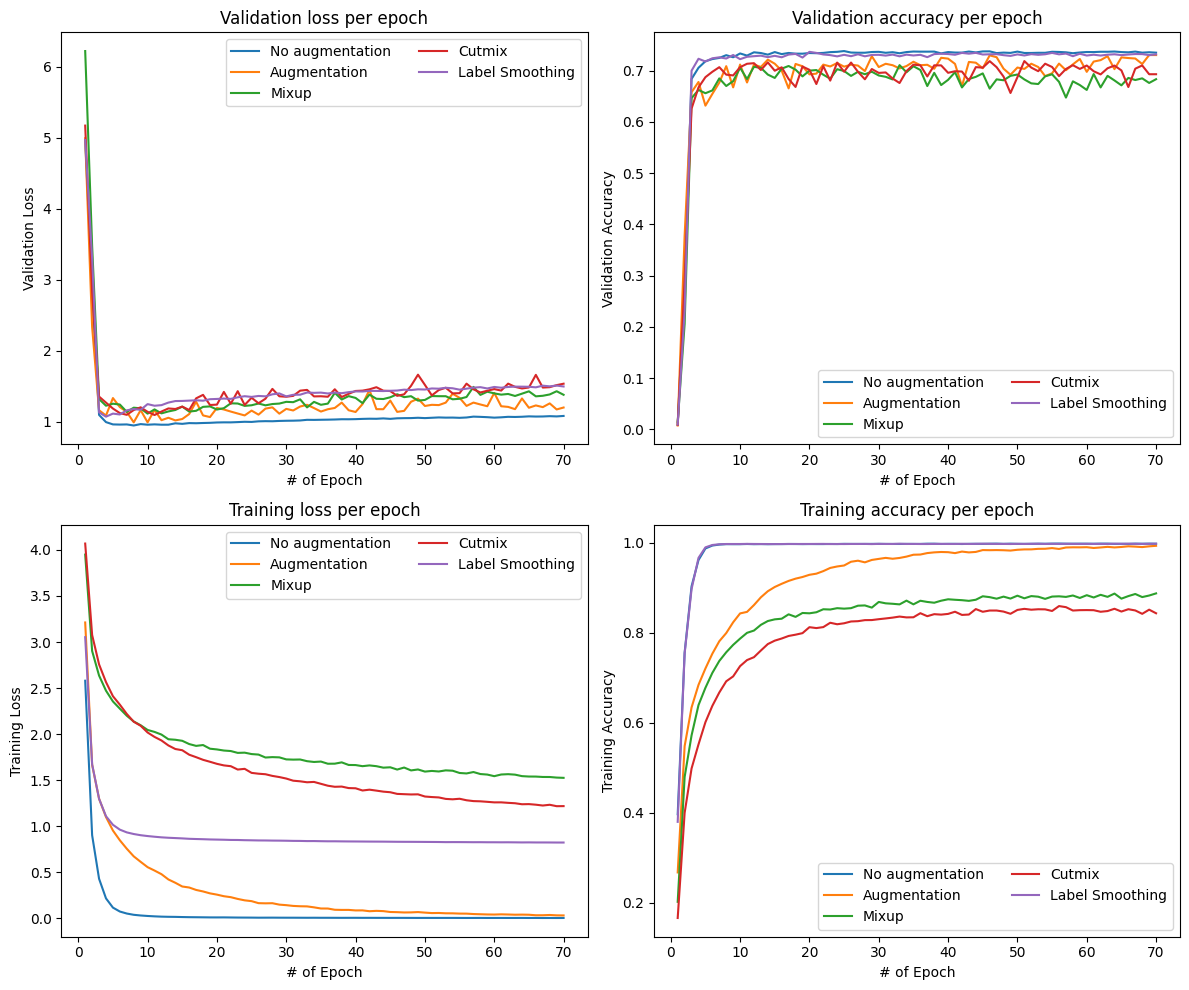

In [44]:
# 모델 train, validation 데이터 plotting
def plot_metrics(ax, histories, labels, metric_name, title, ylabel, loc, ncol):
    for hist, label in zip(histories, labels):
        epochs = range(1, len(hist['val_loss']) + 1)
        ax.plot(epochs, hist[metric_name], label=label)
    ax.set_title(title)
    ax.set_xlabel('# of Epoch')
    ax.set_ylabel(ylabel)
    ax.legend(loc=loc, ncol=ncol)

def plot_training_history(histories, labels):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    plot_metrics(axs[0, 0], histories, labels, 'val_loss', 'Validation loss per epoch', 'Validation Loss', 'upper right', 2)
    plot_metrics(axs[0, 1], histories, labels, 'val_accuracy', 'Validation accuracy per epoch', 'Validation Accuracy', 'lower right', 2)
    plot_metrics(axs[1, 0], histories, labels, 'loss', 'Training loss per epoch', 'Training Loss', 'upper right', 2)
    plot_metrics(axs[1, 1], histories, labels, 'accuracy', 'Training accuracy per epoch', 'Training Accuracy', 'lower right', 2)
    plt.tight_layout()
    plt.show()

# 데이터 불러오기
histories = []
for name in model_names:
    df = pd.read_json(f'{name}c.json')
    histories.append(df.to_dict(orient='list'))
plot_training_history(histories, ['No augmentation', 'Augmentation', 'Mixup', 'Cutmix', 'Label Smoothing'])

### Conclusion

#### 성능 비교:

| Augmentation Method | Converging Epoch | Min Val Loss | Max Val Accuracy |
| --- | --- | --- | --- |
| No Augmentation | 8 | 0.9454 | 0.7385 |
| Default Augmentation | N/A | 0.9897 | 0.7301 |
| MixUp | N/A | 1.1123 | 0.7109 |
| CutMix | N/A | 1.0930 | 0.7188 |
| Label Smoothing | 4 | 1.0700 | 0.7369 |

1. 라벨 스무딩은 MixUp과 CutMix에서 사용하는 라벨 블렌딩이 얼마나 퍼포먼스에 영향을 미칠지 궁금해서 실험에 추가하기로 했다.
2. 실험에서 Augmentation이 적용되거나 MixUp이나 CutMix를 사용하면 더욱 더 과적합이 느리게 왔다.
3. 이에 반해 No augmentation과 단순히 라벨 스무딩을 거친 데이터셋은 더욱 더 빨리 과적합이 찾아왔다.
4. 하지만 augmentation 기법들을 사용한 데이터셋들은 학습 후 일정 accuracy에 도달하는 속도가 느려졌다.
5. 데이터 증강 기법을 적용한 데이터 셋들은 미 적용 데이터 셋들보다 validation 퍼포머스가 낮았다.
6. 데이터 증강은 퍼포먼스 향상이 아닌 조금 더 다양한 데이터 representation을 학습하기 위함(테이터 셋에서 보지 못한 데이터에도 어느정도 추론을 가능케 함?)일 것 같다.
7. 정확도는 No Augmentation -> Label Smoothing -> Augmentation -> CutMix -> MixUp 순으로 하락했다.

#### 느낀 점:

생각보다 학습이 느리게 진행되서 (epochs: 40) 빨리 시작할걸 생각이 들었다. 다른 모듈보다 데이터 증강이 조금 더 직관적이어서 좋았다. (결과 해석 부분은 조금 더 난해했다.)